In [42]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np  
import matplotlib.pyplot as plt

In [43]:
img_size = (256,256)
btch_size = 32

In [44]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory='Potato_village',
    shuffle=True,
    image_size=img_size,
    batch_size=btch_size
)

print(len(dataset))

Found 2152 files belonging to 3 classes.
68


In [45]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


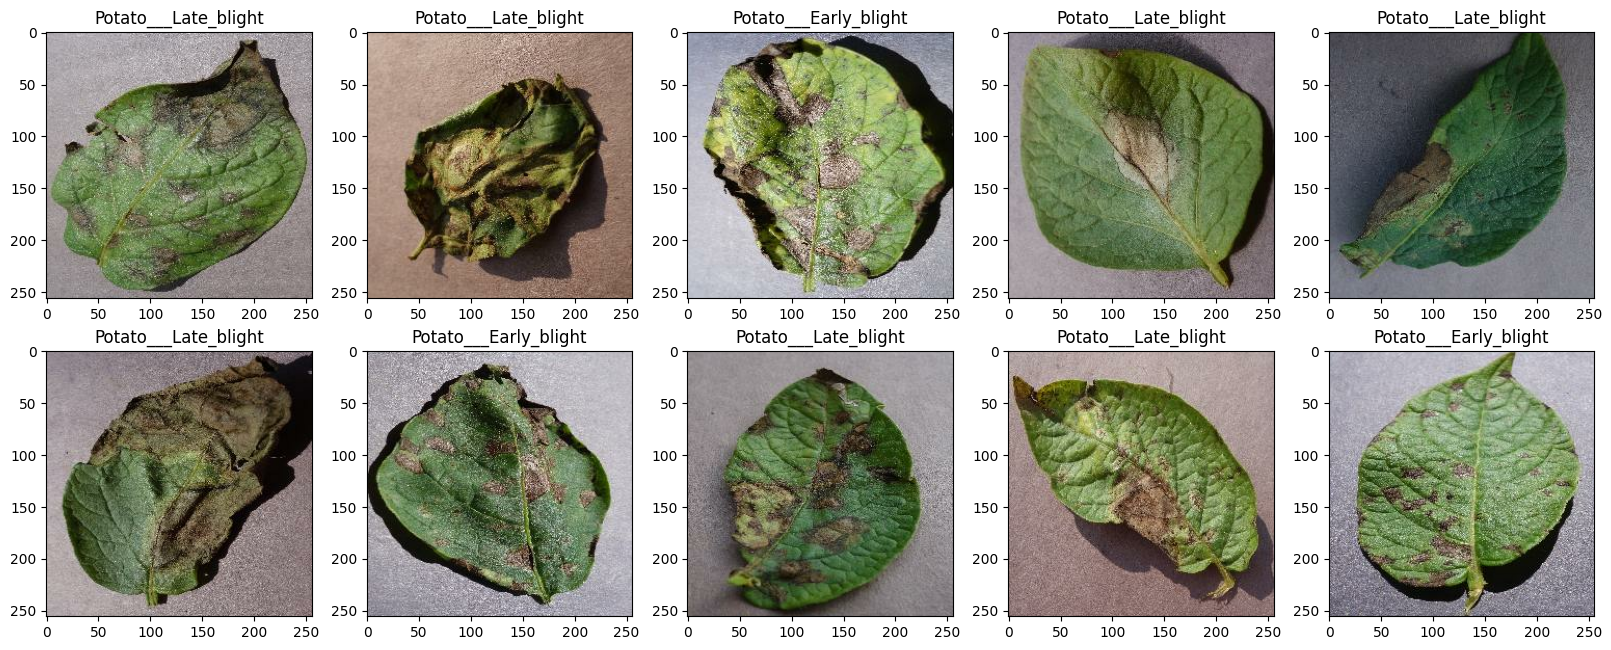

In [46]:
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(20,20))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        

In [47]:
# //train test split

def train_test_split(dataset,test_percentage,val_percentage,train_percentage):
    # test_size=int(test_percentage*len(dataset))
    train_size=int(train_percentage*len(dataset))
    val_size=int(val_percentage*len(dataset))
    
    dataset.shuffle(len(dataset),seed=42)
    
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)


    return train_dataset,val_dataset,test_dataset


train_dataset,val_dataset,test_dataset=train_test_split(dataset,0.1,0.1,0.8)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))



42
13
13


In [48]:
train_dataset=train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
# resize and rescale layer

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1./255)
    
])

In [50]:
# dat aaugmentation layer

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [51]:
# cnn model

num_classes = 3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [52]:
model.build(input_shape=(None,256,256,3))

In [53]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history=model.fit(train_dataset,epochs=10,
          batch_size=32,
          verbose=1
          ,validation_data=val_dataset)



Epoch 1/10
42/42 [==============================] - 111s 2s/step - loss: 0.9691 - accuracy: 0.5722 - val_loss: 1.9462 - val_accuracy: 0.5697
Epoch 2/10
42/42 [==============================] - 98s 2s/step - loss: 0.5355 - accuracy: 0.8103 - val_loss: 0.4299 - val_accuracy: 0.8534
Epoch 3/10
42/42 [==============================] - 99s 2s/step - loss: 0.4420 - accuracy: 0.8348 - val_loss: 0.4551 - val_accuracy: 0.8221
Epoch 4/10
42/42 [==============================] - 91s 2s/step - loss: 0.3293 - accuracy: 0.8713 - val_loss: 0.2861 - val_accuracy: 0.8966
Epoch 5/10
42/42 [==============================] - 91s 2s/step - loss: 0.2854 - accuracy: 0.8929 - val_loss: 0.2062 - val_accuracy: 0.9183
Epoch 6/10
42/42 [==============================] - 104s 2s/step - loss: 0.2616 - accuracy: 0.8996 - val_loss: 0.6938 - val_accuracy: 0.6683
Epoch 7/10
42/42 [==============================] - 91s 2s/step - loss: 0.2776 - accuracy: 0.9025 - val_loss: 0.4077 - val_accuracy: 0.8389
Epoch 8/10
42/42 [

13/13 [==============================] - 6s 321ms/step - loss: 0.1534 - accuracy: 0.9413


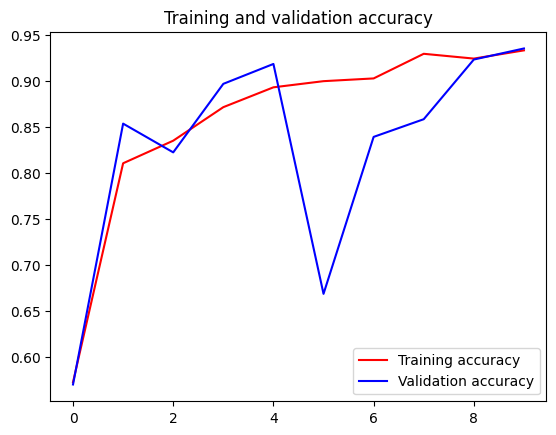

<Figure size 640x480 with 0 Axes>

In [54]:
scores=model.evaluate(test_dataset,verbose=1)

acc=history.history['accuracy']

val_acc=history.history['val_accuracy']

loss=history.history['loss']

val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


(256, 256, 3)
1
1/1 [==============================] - 1s 508ms/step
[[2.9027343e-04 7.9880190e-01 2.0090780e-01]]


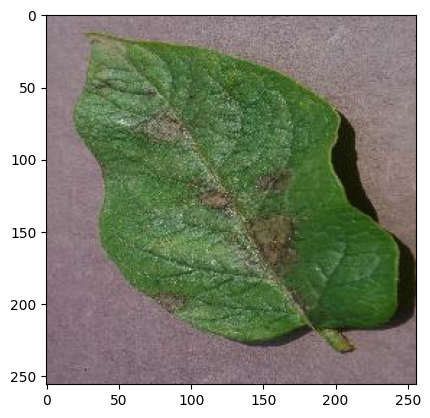

In [55]:
# predict on test data

for image_batch,label_batch in test_dataset.take(1):
    img=image_batch[0].numpy().astype('uint8')
    lbl=label_batch[0].numpy()
    
    print(img.shape)
    print(lbl)
    plt.imshow(img)
    
    prediction=model.predict(np.array([img]))
    
    print(prediction)

In [67]:
scores = model.evaluate(test_dataset)
scores

13/13 [==============================] - 6s 322ms/step - loss: 0.1780 - accuracy: 0.9235


[0.1780022829771042, 0.9234693646430969]

In [56]:
def predict(model,img):
    img=tf.keras.preprocessing.image.load_img(img,target_size=(256,256))
    img=tf.keras.preprocessing.image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=img/255
    prediction=model.predict(img)
    print(prediction)
    predicted_class=np.argmax(prediction,axis=1)
    print(predicted_class)
    
    return predicted_class,prediction

In [65]:
from PIL import Image
import io


for images,label in test_dataset.take(1):
    plt.figure(figsize=(20,20))
    for i in range(10):
        
        img = images[i]
        lbl = label[i].numpy()

        predicted_class, prediction = predict(model, img)
        plt.subplot(5,5,i+1)
        plt.title(class_names[predicted_class[0]])
        plt.imshow(img)
        plt.axis('off')
        
        print(class_names[lbl])
        print(class_names[predicted_class[0]])
        print(prediction)
        
        

TypeError: path should be path-like or io.BytesIO, not <class 'tensorflow.python.framework.ops.EagerTensor'>

<Figure size 2000x2000 with 0 Axes>

In [70]:
# saving model
import os
model_version= max([int(i) for i in os.listdir('saved_models')]+[0])+1
file_path=f"saved_models/{model_version}"
model.save(file_path,save_format='tf')



INFO:tensorflow:Assets written to: saved_models/2\assets


INFO:tensorflow:Assets written to: saved_models/2\assets
